In [1]:
import numpy as onp
import matplotlib.pyplot as plt

import jax 
from jax import config, jit, vmap, grad 
config.update("jax_enable_x64", True)
import jax.numpy as np
import jax.scipy as jsp


import pyoifits as oifits

from drpangloss.models import *
from drpangloss.plotting import *
from drpangloss.grid_fit import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


First, load some data. We use `pyoifits` for its easy syntax: this then fills out the fields of an `OIData` zodiax object which we will use in fitting.

In [2]:
fname = "NuHor_F480M.oifits"
ddir = "../data/"

data = oifits.open(ddir+fname)

data.verify('silentfix')

oidata = OIData(data)

Rather than use the real, slightly ratty, JWST/AMI F480M data, let's use some simulated data. You can also pass a dictionary of the appropriate keys to initialize `OIData`: 

In [3]:
true_values = [150., 150., 5e-4] # ra, dec, planet flux
binary = BinaryModelCartesian(true_values[0], true_values[1], true_values[2])

cvis_sim = binary.model(oidata.u, oidata.v, oidata.wavel)

# fill out a new oidata model with simulated values
sim_data = {'u': oidata.u,
            'v': oidata.v,
            'wavel': oidata.wavel,
            'vis': (oidata.to_vis(cvis_sim) + (onp.random.randn(*oidata.vis.shape)*oidata.d_vis)),
            'd_vis': oidata.d_vis,
            'phi': (oidata.to_phases(cvis_sim) + (onp.random.randn(*oidata.phi.shape)*oidata.d_phi)),
            'd_phi': oidata.d_phi,
            'i_cps1': oidata.i_cps1,
            'i_cps2': oidata.i_cps2,
            'i_cps3': oidata.i_cps3,
            'v2_flag': oidata.v2_flag,
            'cp_flag': oidata.cp_flag}

oidata_sim = OIData(sim_data)

In the following, we will use `params = ["dra", "ddec", "flux"]` as a hard coded list of the parameters passed to `BinaryModelCartesian`, which calculates a binary model given an RA, Dec, and Flux. While we have not implemented the features yet, in future we plan to have `BinaryModelAngular` use `params = ["sep", "pa", "contrast"]` and to have the fitting functions appropriately recognise which coordinates are being used from this `params` list.

We can calculate a simple Gaussian likelihood, using a fast `vmap` syntax to evaluate this on a dense grid of points in RA, Dec, and Flux. This grid is created using `np.meshgrid` where necessary, automatically from a `samples_dict` object containing the 1-D coordinate arrays.

In [7]:
params = ["dra", "ddec", "flux"]

samples_dict = {
    "dra":  np.linspace(600., -600., 100), # left is more RA 
    "ddec": np.linspace(-600., 600., 100), # up is more dec
    "flux": 10**np.linspace(-6, -1, 200)
    }

loglike_im = likelihood_grid(oidata_sim, BinaryModelCartesian, samples_dict) # calculate once to jit

We have abstracted most of the plotting functions to `drpangloss.plotting` so that these are straightforward to use and provide consistent results. 

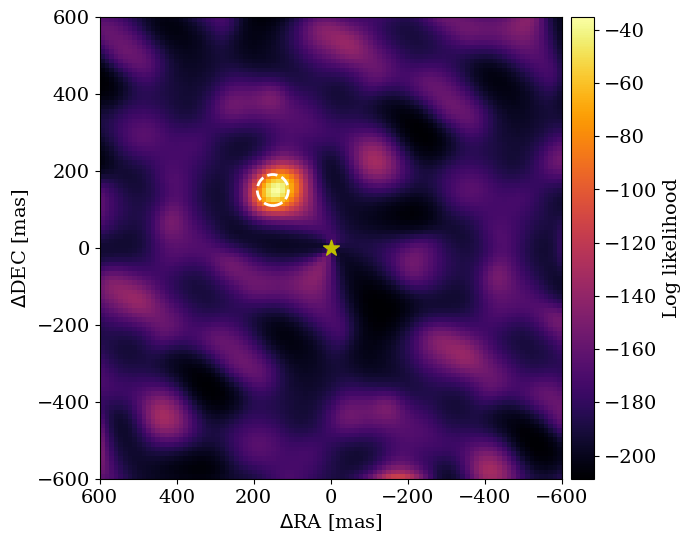

In [8]:
plot_likelihood_grid(loglike_im, samples_dict, truths=true_values)

We can use gradient descent to optimize the best-fitting contrast in each pixel - we find that it isn't very different to the grid:

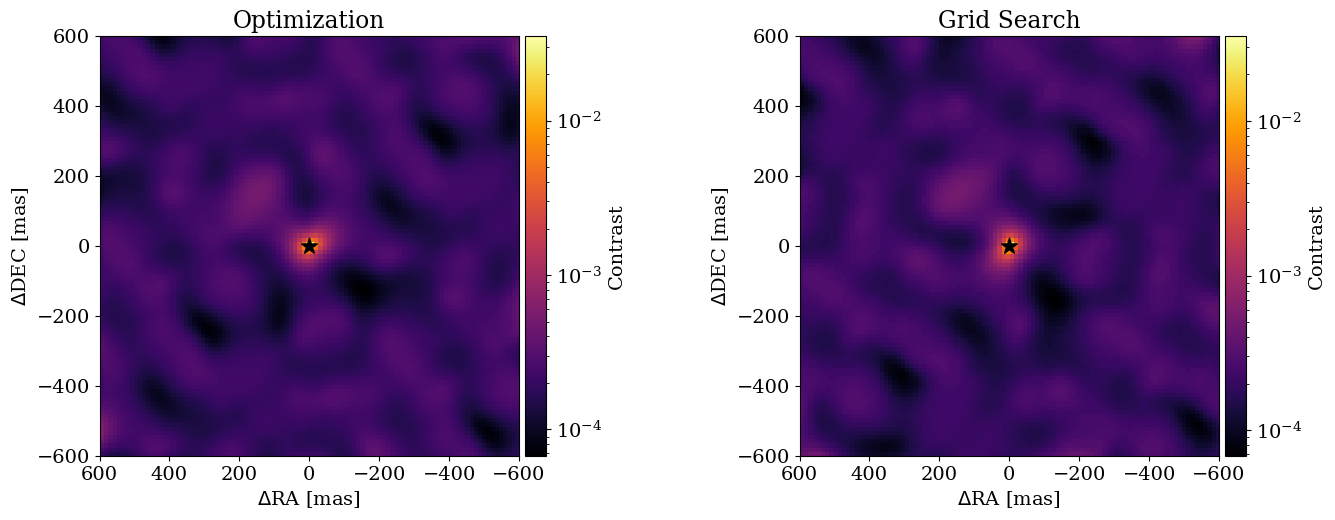

In [9]:
best_contrast_indices = np.argmax(loglike_im,axis=2)
best_contrasts = samples_dict['flux'][best_contrast_indices]

optimized = optimized_contrast_grid(oidata_sim, BinaryModelCartesian, samples_dict)

plot_optimized_and_grid(loglike_im, optimized, samples_dict)

We can use the Laplace approximation to infer the uncertainty on the best-fitting flux in each pixel:

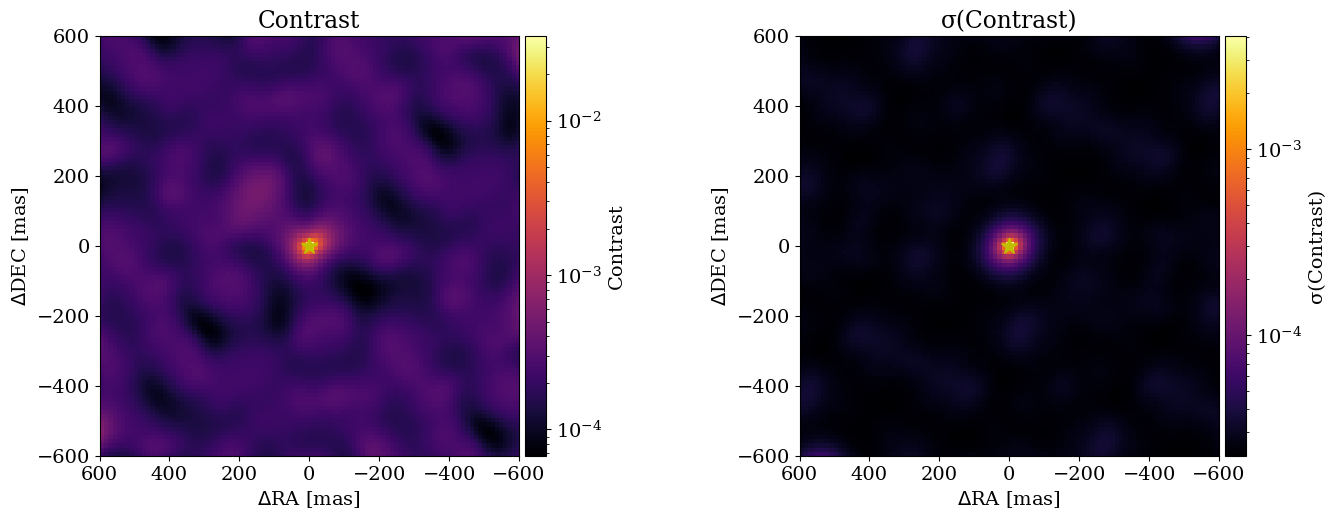

In [10]:
laplace_sigma_grid = laplace_contrast_uncertainty_grid(best_contrast_indices, oidata_sim, BinaryModelCartesian, samples_dict)
plot_optimized_and_sigma(optimized, laplace_sigma_grid, samples_dict,snr=False)

We can alternatively plot the SNR:

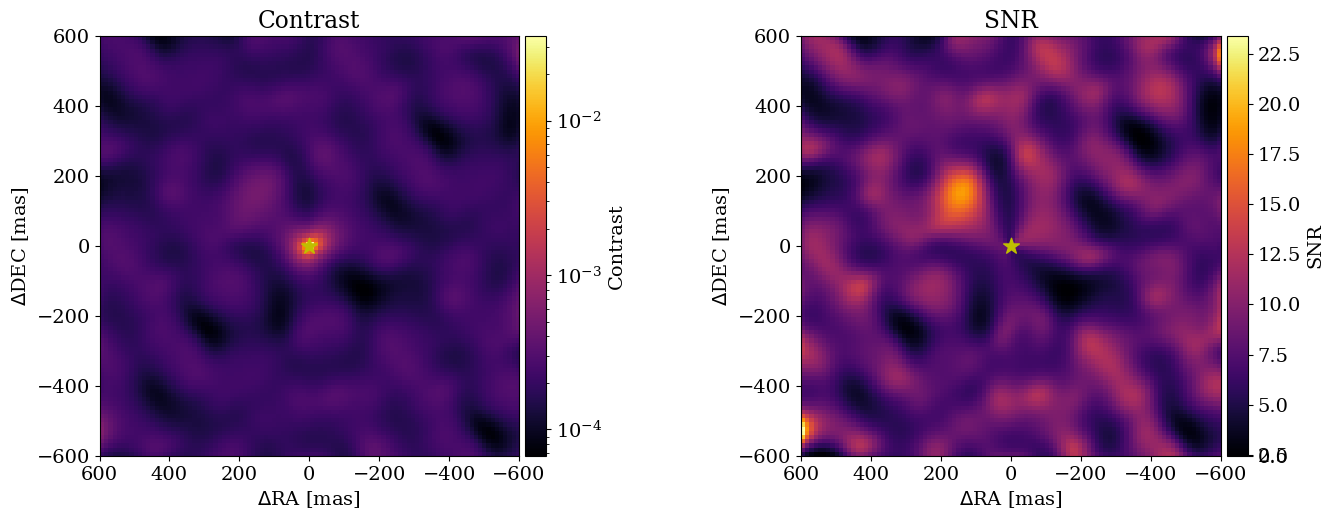

In [11]:
plot_optimized_and_sigma(optimized, laplace_sigma_grid, samples_dict,snr=True)

## Ruffio Contrast Limits

The [Ruffio et al 2018](https://ui.adsabs.harvard.edu/abs/2018AJ....156..196R/abstract) method for contrast limits is Bayesian - you infer the Gaussian posterior on flux of a companion, and impose a prior that the flux is positive. Then you report a chosen percentile of this as the flux upper limit for a nondetection, *conditioned on this being the correct astrometry and there being a real source there*. 

In [13]:
# this implementation is in the old syntax

perc = np.array([jsp.stats.norm.cdf(2.)])
limits = ruffio_upperlimit(optimized.flatten(),laplace_sigma_grid.flatten(),perc)
limits_rs = limits.reshape(*optimized.shape,perc.shape[0])[:,:,0]

# TODO: fix this syntax to be more readable
rad_width_ruffio, avg_width_ruffio  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:]), returnradii=True, binsize=2, stddev=False)
_, std_width_ruffio  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:]), returnradii=True, binsize=2, stddev=True)

Text(0.5, 1.05, 'Ruffio Method')

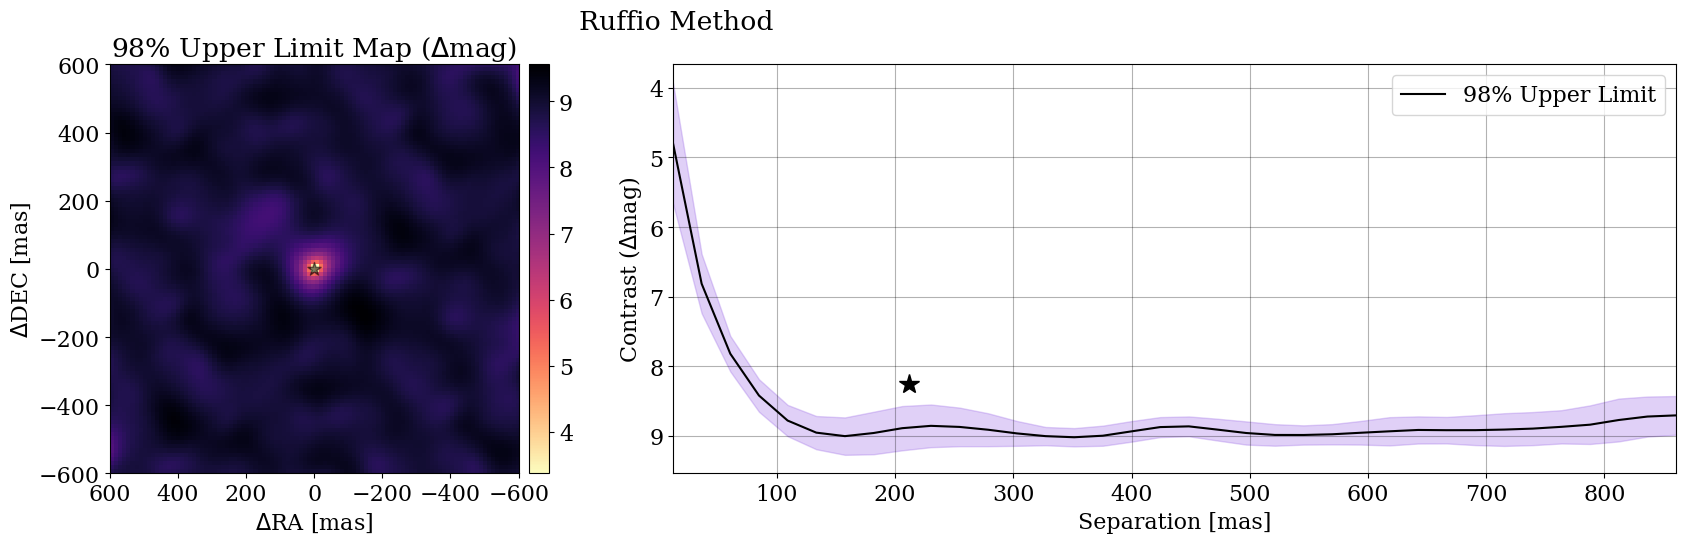

In [14]:
plot_contrast_limits(limits_rs, samples_dict, rad_width_ruffio, avg_width_ruffio, std_width_ruffio,true_values=true_values)
plt.suptitle('Ruffio Method',y=1.05)

## Absil Contrast Limits

In [Absil et al 2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...535A..68A/abstract), a frequentist p-value is used to infer an upper limit from data. This is done by a chi-squared hypothesis test, inferring what the highest contrast would be such that it would have been detected at n-σ. 

In [15]:
limits_absil = absil_limits(samples_dict, oidata, BinaryModelCartesian, 5.) # TODO: check this, results look a bit different from Dori implementation

# TODO: make this syntax more readable
rad_width_absil, avg_width_absil  = azimuthalAverage(-2.5*np.log10(limits_absil[:,:]), returnradii=True, binsize=2, stddev=False)
_, std_width_absil  = azimuthalAverage(-2.5*np.log10(limits_absil[:,:]), returnradii=True, binsize=2, stddev=True)

Text(0.5, 1.05, 'Absil Method')

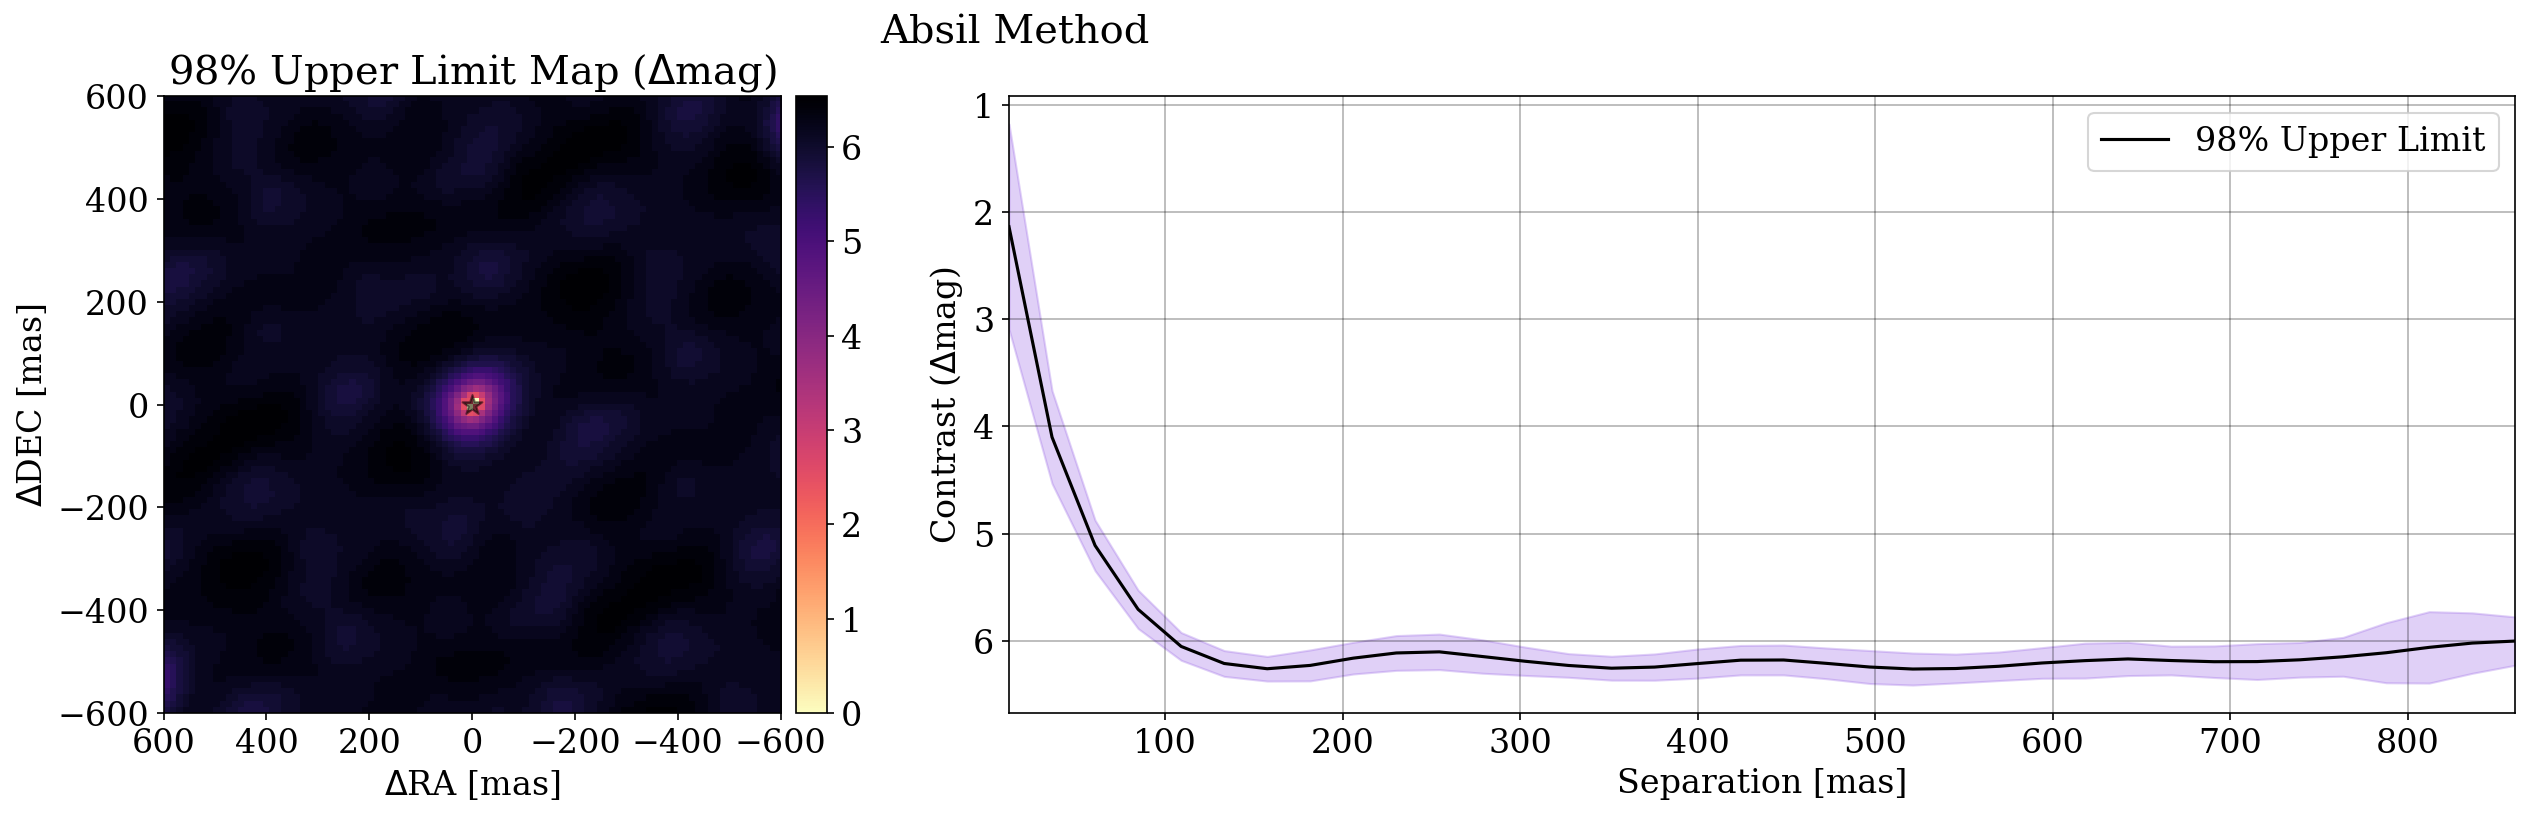

In [16]:
plot_contrast_limits(limits_absil, samples_dict, rad_width_absil, avg_width_absil, std_width_absil)
plt.suptitle('Absil Method',y=1.05)